# Supplemental analysis: Comparing time to run NZ versus networkx clustering algorithms


In [13]:
# Auto-reloads external files any changes are automatically reflected
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import random
import time
import math
from tqdm import tqdm,tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Networkx implementation only

In [5]:
class NetworkGeneration_nx(object):
    def __init__(self,N,p,process_name,m=0):
        self.N = N # nodes, 3.6e5 in paper
        self.p = p
        self.m = m
        self.t = N*p # edges to add
        self.N_list = list(np.arange(self.N).astype(int))
        self.process = process_name    
    
    def build(self):
        if self.process=='ER': self.ER()
        elif self.process=='AP': self.AP()
        elif self.process=='DPR': self.DPR()
        else: print('build with a valid process')
            
    def calculate_edge_product(self,G,edge_tuple):
        return (G.degree[edge_tuple[0]]+1)*(G.degree[edge_tuple[1]]+1)

    def calculate_edge_cluster_sizes(self,G,edge_tuple):
        return len(nx.node_connected_component(G,edge_tuple[0])) + len(nx.node_connected_component(G,edge_tuple[1]))
    
    def ER(self):
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an ER network")
        while len(G.edges)<self.t:
            proposed_edge = (random.choice(self.N_list),random.choice(self.N_list))
            G.add_edge(proposed_edge[0],proposed_edge[1])
            C.append(len(max(nx.connected_component_subgraphs(G), key=len))/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G
            
    def DPR(self):
        # DPR: goes to smallest product of the degrees of connection
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building a DPR network")
        while len(G.edges)<self.t:
            proposed_edges = [(random.choice(self.N_list),random.choice(self.N_list)) for _ in range(self.m)]
            proposed_edge_weights = [self.calculate_edge_product(G,edge_tuple) for edge_tuple in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            C.append(len(max(nx.connected_component_subgraphs(G), key=len))/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G
            
    def AP(self):
        # AP: goes to smallest sum of clusters connected to each node
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an AP network")
        while len(G.edges)<self.t:
            proposed_edges = [(random.choice(self.N_list),random.choice(self.N_list)) for _ in range(self.m)]
            proposed_edge_weights = [self.calculate_edge_cluster_sizes(G,edge_tuple) for edge_tuple in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            C.append(len(max(nx.connected_component_subgraphs(G), key=len))/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G

## NZ algorithms

In [6]:
class NetworkGeneration(object):
    def __init__(self,N,p,process_name,m=0):
        self.N = N # nodes, 3.6e5 in paper
        self.p = p
        self.m = m
        self.t = N*p # edges to add
        self.ptr = np.nan*np.ones(int(N)) # ptr empty array for NZ algorithm
        self.N_list = list(np.arange(self.N).astype(int))
        self.process = process_name
    
    def build(self):
        if self.process=='ER': self.ER()
        elif self.process=='AP': self.AP()
        elif self.process=='DPR': self.DPR()
        else: print('build with a valid process')
            
    def calculate_edge_product(self,G,edge_tuple):
        return (G.degree[edge_tuple[0]]+1)*(G.degree[edge_tuple[1]]+1)
            
    def calculate_edge_cluster_sum(self,edge_tuple):
        return sum([self.NZ_root_value(int(node)) for node in edge_tuple])
    
    def ER(self):
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an ER network")
        while len(G.edges)<self.t:
            proposed_edge = (np.random.choice(self.N_list,2,replace=False))
            G.add_edge(proposed_edge[0],proposed_edge[1])
            self.NZ_update(proposed_edge)
            C.append(-np.amin(self.ptr[np.where(np.logical_not(np.isnan(self.ptr)))])/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G
            
    def DPR(self):
        # DPR: goes to smallest product of the degrees of connection
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building a DPR network")
        while len(G.edges)<self.t:
            proposed_edges = ([np.random.choice(self.N_list,2,replace=False) for _ in range(self.m)])
            proposed_edge_weights = [self.calculate_edge_product(G,edge_tuple) for edge_tuple in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            self.NZ_update(winning_edge)
            C.append(-np.amin(self.ptr[np.where(np.logical_not(np.isnan(self.ptr)))])/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G

    def find_root(self,node):
        if self.ptr[int(node)]<0: return int(node) # root of a tree
        elif math.isnan(self.ptr[int(node)]): return int(node) # solo node
        else: return self.find_root(int(self.ptr[int(node)])) # node points to a root, find root location

    def NZ_root_value(self,node):
        root = self.find_root(int(node))
        if math.isnan(self.ptr[int(root)]): return 1
        else: return int(-self.ptr[root])
        
    def NZ_update(self,nodes_added):
        roots = (self.find_root(nodes_added[0]),self.find_root(nodes_added[1]))
        if roots[0]==roots[1]: return
        
        # get cluster size at each root (NZ_root_value automatically calculates as 1 for solo)
        cluster_size = [self.NZ_root_value(root) for root in roots]
        if cluster_size==sorted(cluster_size): smaller_node=nodes_added[0]; larger_node=nodes_added[1]
        else: smaller_node=nodes_added[1]; larger_node=nodes_added[0]
            
        # have nodes within the smaller cluster to point to the larger cluster
        smaller_root_loc = self.find_root(smaller_node)
        larger_root_loc = self.find_root(larger_node)
        np.place(self.ptr,(self.ptr==smaller_root_loc),larger_root_loc)
        
        # add the number of nodes in the smaller cluster to the larger cluster
        self.ptr[larger_root_loc] = -(self.NZ_root_value(larger_root_loc) + self.NZ_root_value(smaller_root_loc))
        
        # point the smaller root to the larger root
        self.ptr[smaller_root_loc] = larger_root_loc
    
    def AP(self):
        # AP: goes to smallest sum of clusters connected to each node
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an AP network")
        while len(G.edges)<self.t:
            proposed_edges = [np.random.choice(self.N_list,2,replace=False) for _ in range(self.m)]
            proposed_edge_weights = [self.calculate_edge_cluster_sum(edge) for edge in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            self.NZ_update(winning_edge)
            C.append(-np.amin(self.ptr[np.where(np.logical_not(np.isnan(self.ptr)))])/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G

## Speed test

In [ ]:
# Set test parameters
p = 1
N_space = np.asarray([1e2,2.5e2,5e2,7.5e2,1e3])

In [14]:
# Newman-Ziff implementation

t_ER = []
t_DPR = []
t_AP = []

for N_test in N_space:
    test_ER = NetworkGeneration(N_test,p,'ER')
    test_DPR = NetworkGeneration(N_test,p,'DPR',m=2)
    test_AP = NetworkGeneration(N_test,p,'AP',m=2)
    start=time.time()
    test_ER.build()
    t_ER.append(time.time()-start)
    start=time.time()
    test_DPR.build()
    t_DPR.append(time.time()-start)
    start=time.time()
    test_AP.build()
    t_AP.append(time.time()-start)

In [16]:
# Networkx implementation

t_nx_ER = []
t_nx_DPR = []
t_nx_AP = []

for N_test in N_space:
    test_ER = NetworkGeneration_nx(N_test,p,'ER')
    test_DPR = NetworkGeneration_nx(N_test,p,'DPR',m=2)
    test_AP = NetworkGeneration_nx(N_test,p,'AP',m=2)
    start=time.time()
    test_ER.build()
    t_nx_ER.append(time.time()-start)
    start=time.time()
    test_DPR.build()
    t_nx_DPR.append(time.time()-start)
    start=time.time()
    test_AP.build()
    t_nx_AP.append(time.time()-start)

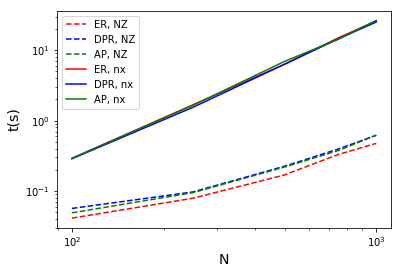

In [20]:
# Plot results

plt.loglog(N_space,t_ER,'r--',label='ER, NZ')
plt.loglog(N_space,t_DPR,'b--',label='DPR, NZ')
plt.loglog(N_space,t_AP,'g--',label='AP, NZ')
plt.loglog(N_space,t_nx_ER,'r',label='ER, nx')
plt.loglog(N_space,t_nx_DPR,'b',label='DPR, nx')
plt.loglog(N_space,t_nx_AP,'g',label='AP, nx')
plt.ylabel('t(s)')
plt.xlabel('N')
plt.legend()
plt.show()